# Model C: BEiT fine tuned on ImageNet-22k

*Note: This notebook is mainly for preview and is the final version for model C for our submission. If you wish to run the notebook, please go to BEiT/beit.ipynb in the directory and put the necessary folders there.*

This notebook uses the model from https://huggingface.co/microsoft/beit-base-patch16-224-pt22k-ft22k

BEiT aka `Bidirectional Encoder representation from Image Transformers` is a Vision Transformer which uses relative potion embeddings instead of absolute position embeddings. This particular BEiT model was trained on 14 million images with nearly 22k classes at a resolution of 224x224.

In this notebook, we train the BEiT model to be able to classify potato diseases. There are 6 main classes:
- Healthy
- Bacteria
- Virus
- Pest
- Fungi
- Phytopthora

It is trained with the potato train dataset, then it is finetuned to make it better at differentiating between specific potato diseases which it struggles to differentiate.

All seeds have already been set to 42, however if you will run torch using cuda, expect there to still be slight variations in the results if you rerun it. This is due to torch using non-deterministic algorithms (these are 3x faster than deterministic ones for this model at least from my testing).

In [1]:
## if running in Google Colab, do these
# !pip install datasets=='3.5.1' evaluate torch torchvision transformers Pillow numpy scikit-learn 'accelerate>=0.26.0'

### Training the model

First we load the dataset from the directory. The filename is appended to the dataset for our convenience in a future step, but it is not necessary for training the model.

In [3]:
from datasets import load_dataset, Image
import os
"""
.venv/Scripts/activate

python -m image_process
"""
base_output_dir = "model" ## if you wanna save different models, just make a new git branch, saving a VIT model takes up A LOT of space
os.makedirs(base_output_dir, exist_ok=True)
dataset = load_dataset("potato_train/train")
filenames_ds = load_dataset("potato_train/train").cast_column("image", Image(decode=False))

filename_col = [x['image']['path'].split('\\')[-1] for x in filenames_ds['train']]
dataset['train'] = dataset['train'].add_column("filename", filename_col)

We retrieve the feature extractor from our desired BEiT model

In [ ]:
from transformers import BeitImageProcessor

model_id = 'microsoft/beit-base-patch16-224-pt22k-ft22k'
feature_extractor = BeitImageProcessor.from_pretrained(
    model_id
)
feature_extractor

c:\Users\TahirLidasanJr\Documents\GitHub\cs180-project\.venv\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

These are the steps used to preprocess the images and to perform data augmentation on the training dataset. We also set all the seeds to 42 to ensure some level of consistency.

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
    Resize,
    ToTensor,
    ColorJitter,
    RandomAffine,
)
from PIL import Image  # Import PIL for RandomAffine's resample
import torch
import numpy as np

def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 42
set_seeds(seed)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
size = (feature_extractor.size["height"], feature_extractor.size["width"])

training_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    RandomRotation((-30, 30)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.05),
    RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), interpolation=Image.BILINEAR),
    ToTensor(),
    normalize
])

def training_image_preprocess(batch):
    batch["pixel_values"] = torch.stack([training_transforms(img) for img in batch["image"]])
    return batch

def preprocess(batch):
    inputs = feature_extractor(batch['image'], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

In [6]:
import torch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

We split the train dataset. 80% for training, 20% for testing.

In [7]:
train_test_split = dataset["train"].train_test_split(test_size=0.2, shuffle=True, seed=42)
dataset_train = train_test_split["train"]
dataset_test = train_test_split["test"]

The code below shows the class labels of our potato dataset

In [8]:
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(6,
 ClassLabel(names=['Bacteria', 'Fungi', 'Healthy', 'Pest', 'Phytopthora', 'Virus'], id=None))

In [9]:
prepared_train = dataset_train.with_transform(training_image_preprocess)
prepared_test = dataset_test.with_transform(preprocess)

We save the images of preprocessed training images without the normalization. This lets us see the effects of the data augmentation to the training dataset.

In [10]:
import os
from torchvision.transforms.functional import to_pil_image

preview_training_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    RandomRotation((-30, 30)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.05),
    RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), interpolation=Image.BILINEAR),
    ToTensor(),
])

def preview_training_image_preprocess(batch):
    batch["pixel_values"] = torch.stack([preview_training_transforms(img) for img in batch["image"]])
    return batch

def save_unnormalized_images(prepared_dataset, raw_dataset, directory: str):
    os.makedirs(directory, exist_ok=True)
    for index, item in enumerate(prepared_dataset):
        if index >= 10:
            break
        pixel_values = item["pixel_values"]
        image = to_pil_image(pixel_values)
        label_filename = raw_dataset[index]["filename"]

        name_without_extension, extension = os.path.splitext(label_filename)
        filename = f"pp_{name_without_extension}.png"

        filepath = os.path.join(directory, filename)
        image.save(filepath)

preview_train = dataset_train.with_transform(preview_training_image_preprocess)
save_unnormalized_images(preview_train, dataset_train, f"{base_output_dir}/preprocessed_train_images")

Shown here are some of the processed images from the training dataset. More can be seen in the newly created folder from the previous cell.

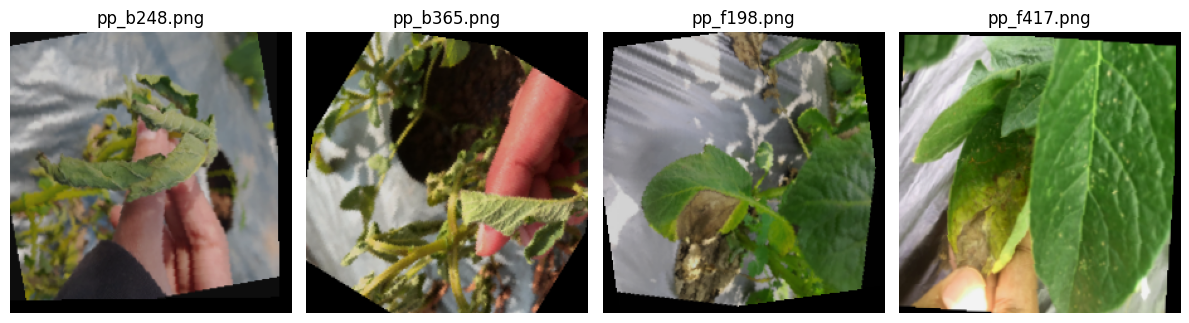

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import os

image_directory = f"{base_output_dir}/preprocessed_train_images"
image_files = [f for f in os.listdir(image_directory) if f.endswith('.png')]

plt.figure(figsize=(12, 12))

for i in range(min(4, len(image_files))):
    img_path = os.path.join(image_directory, image_files[i])
    img = Image.open(img_path)

    plt.subplot(1, 4, i + 1) # 1 row, 4 columns, current subplot
    plt.imshow(img)
    plt.title(f"{image_files[i]}")
    plt.axis('off') # Hide axes for cleaner display

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

Defining the metrics for the model
- accuracy and f1 with weighted average.

In [12]:
import evaluate

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    results = {}
    results.update(accuracy_metric.compute(
        predictions=predictions, 
        references=p.label_ids,))
    results.update(f1_metric.compute(
        predictions=predictions, 
        references=p.label_ids, 
        average="weighted"))
    return results

Training Arguments with
- L2 regularization with weight decay = 0.01
- 30 epochs
- initial learning rate: 5e-5
- learning rate scheduler type: cosine, with the first 10% of the epoch as warmup

In [13]:
from transformers import BeitForImageClassification, Trainer, TrainingArguments, BeitConfig
# from transformers.trainer_callback import EarlyStoppingCallback
import hf_xet

training_args = TrainingArguments(
  output_dir=base_output_dir,
  per_device_train_batch_size=16,
  eval_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=30,
  logging_steps=100,
  learning_rate=5e-5,
  save_total_limit=2,
  seed=seed,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
  weight_decay=0.01,  # Add this line to apply L2 regularization
  lr_scheduler_type="cosine",  # Use cosine learning rate scheduler
  warmup_steps=int(0.1 * (len(prepared_train) / 16) * 100), # 10% of the first epoch for warmup
  # ^ Adjust warmup_steps based on your dataset size and batch size
)
config = BeitConfig.from_pretrained(model_id)
config.num_labels = len(dataset_train.features['label'].names)
# If you want to change it (do this BEFORE loading the model with from_pretrained):
# config.hidden_dropout_prob = 0.2
# config.attention_probs_dropout_prob = 0.2
print(f"hidden dropout={config.hidden_dropout_prob}, attention dropout={config.attention_probs_dropout_prob}")

model = BeitForImageClassification.from_pretrained(
    model_id,  # classification head
    config=config,
    ignore_mismatched_sizes=True
)
model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    processing_class=feature_extractor,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0.001)],
)

hidden dropout=0.0, attention dropout=0.0


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now we train the model. This will also save the 2 best models during the training to the specified directory.

In [12]:
train_results = trainer.train()

trainer.save_model() # save tokenizer with the model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

trainer.save_state() # save the trainer state

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.691700,1.228397,0.575646,0.569649
2,1.117600,0.548593,0.817343,0.813286
3,0.436200,0.403320,0.850554,0.846480
4,0.349000,0.358127,0.856089,0.857699
5,0.345800,0.304224,0.894834,0.894659
6,0.264500,0.380967,0.863469,0.862480
7,0.274700,0.417570,0.859779,0.859360
8,0.252400,0.422987,0.874539,0.873306
9,0.229800,0.372052,0.885609,0.885423
10,0.205400,0.388620,0.892989,0.892175


***** train metrics *****
  epoch                    =         30.0
  total_flos               = 4685608631GF
  train_loss               =        0.203
  train_runtime            =   1:44:52.89
  train_samples_per_second =       10.321
  train_steps_per_second   =        0.648


### Training Analysis

Now we plot the results of the 30 Epochs training. We see that the gap between training and validation loss starts getting bigger by Epoch 6, and by Epoch 30 the training loss is very near 0 while validation loss is more than 0.60

Moving onto accuracy and f1-score, we see that the later epochs can reach 0.90 near the end, but surprisingly Epoch 5 reached 0.89

Epoch 5 has the smallest validation loss with a very small gap between training and validation loss. Hence Epoch 5 is our best model as it generalizes well and it has good metrics.

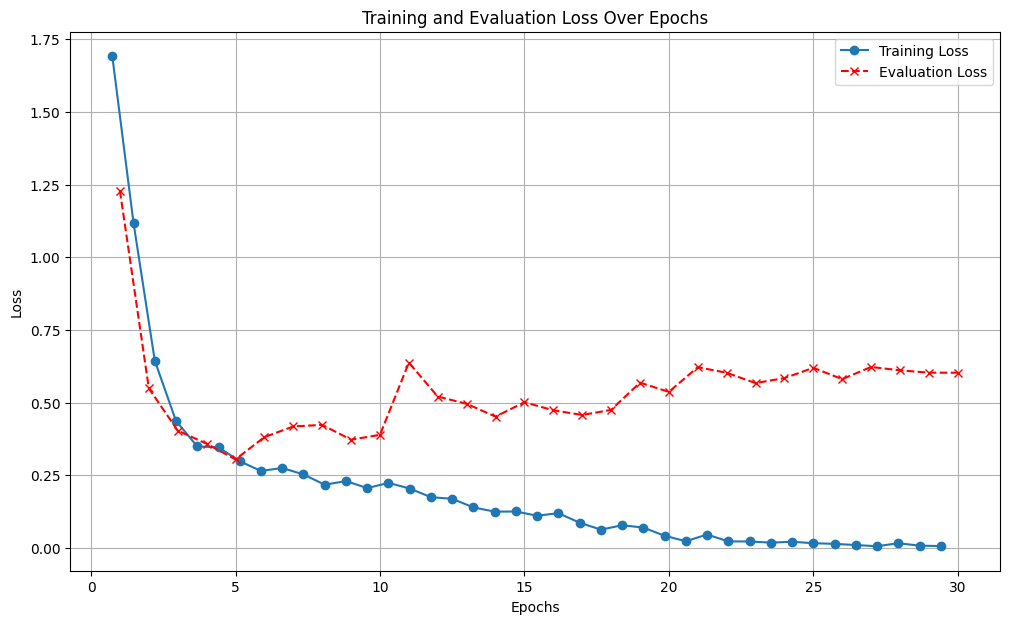

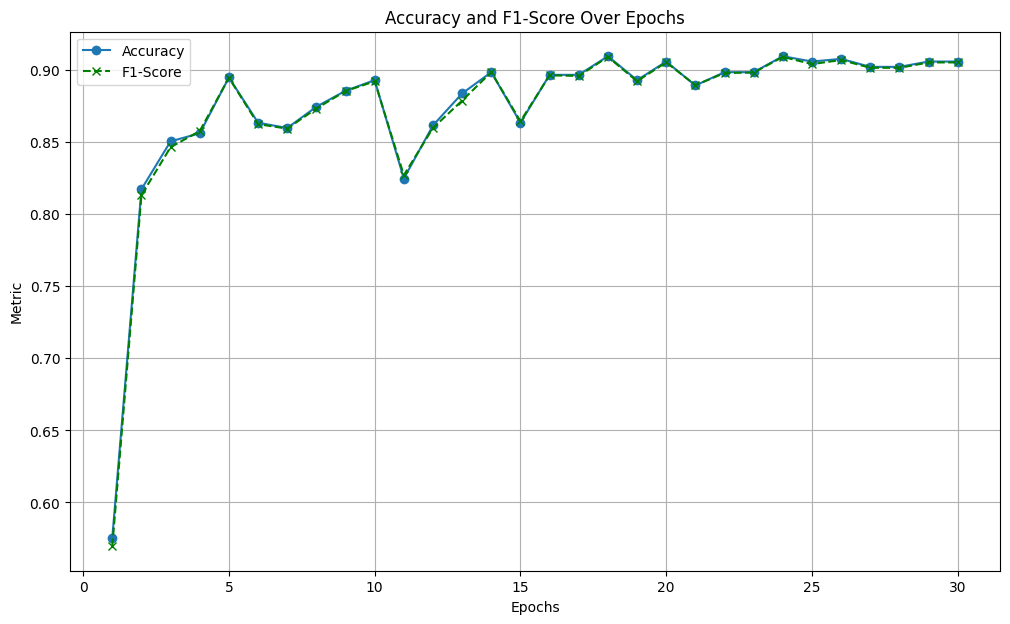

In [41]:
import matplotlib.pyplot as plt

def plot_graph(file_path: str):
    with open(file_path, 'r') as f:
        data = json.load(f)
    filtered_log_history = []
    log_history = data['log_history']
    for entry in log_history:
        has_epoch = 'epoch' in entry
        has_loss = 'loss' in entry
        has_eval_loss = 'eval_loss' in entry
        has_accuracy = 'eval_accuracy' in entry
        has_f1 = 'eval_f1' in entry
        if has_epoch and (has_loss or has_eval_loss or has_accuracy or has_f1):
            filtered_log_history.append(entry)

    train_losses = [item.get('loss') for item in filtered_log_history if 'loss' in item]
    train_epochs = [item.get('epoch') for item in filtered_log_history if 'loss' in item]
    eval_losses = [item.get('eval_loss') for item in filtered_log_history if 'eval_loss' in item]
    eval_epochs = [item.get('epoch') for item in filtered_log_history if 'eval_loss' in item]
    
    ac_f1_epochs = [item.get('epoch') for item in filtered_log_history if 'eval_accuracy' in item]
    eval_accuracy = [item.get('eval_accuracy') for item in filtered_log_history if 'eval_accuracy' in item]
    eval_f1 = [item.get('eval_f1') for item in filtered_log_history if 'eval_f1' in item]

    plt.figure(figsize=(12, 7))
    plt.plot(train_epochs, train_losses, marker='o', linestyle='-', label='Training Loss')
    plt.plot(eval_epochs, eval_losses, marker='x', linestyle='--', color='red', label='Evaluation Loss')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()      
    
    plt.figure(figsize=(12, 7))
    plt.plot(ac_f1_epochs, eval_accuracy, marker='o', linestyle='-', label='Accuracy')
    plt.plot(ac_f1_epochs, eval_f1, marker='x', linestyle='--', color='green', label='F1-Score')

    plt.xlabel("Epochs")
    plt.ylabel("Metric")
    plt.title("Accuracy and F1-Score Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_graph(f"{base_output_dir}/trainer_state.json")

We retrieve the saved model (Epoch 5 with checkpoint step 680) from the directory, then run the evaluation.

In [96]:
from transformers import Trainer, BeitForImageClassification, BeitImageProcessor

checkpoint = '680'
model = BeitForImageClassification.from_pretrained(f'{base_output_dir}/checkpoint-{checkpoint}')
feature_extractor = BeitImageProcessor.from_pretrained(f'{base_output_dir}/checkpoint-{checkpoint}')

# Define the Trainer for evaluation
# (if you don't wanna load the model from the directory and use the trained model directly, comment out the trainer line here)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    processing_class=feature_extractor,
)
eval_results = trainer.evaluate()

trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)

***** eval metrics *****
  eval_accuracy               =     0.8948
  eval_f1                     =     0.8947
  eval_loss                   =     0.3042
  eval_model_preparation_time =        0.0
  eval_runtime                = 0:00:24.61
  eval_samples_per_second     =     22.016
  eval_steps_per_second       =      2.762


Now we show the confusion matrix of the trained model. We can see that despite the high accuracy and f1-score, the model struggles the most with fungi and phytopthora images.

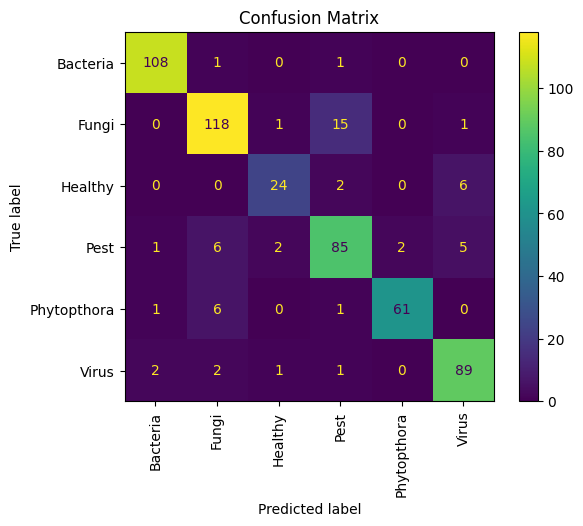

In [97]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def show_confusion_matrix(test_dataset, model):
    true_y = test_dataset[:]["label"]
    test = test_dataset[:]["pixel_values"]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test = test.to(device)

    # Make predictions
    with torch.no_grad():
        model.eval() 
        logits = model(test).logits
        pred_y = torch.argmax(logits, dim=-1).cpu().tolist()

    class_names = labels.names

    cm = confusion_matrix(true_y, pred_y)

    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
    cm_display.plot(xticks_rotation='vertical', values_format='d') 
    plt.title('Confusion Matrix')
    plt.show()

show_confusion_matrix(prepared_test, model)

Note that the ID's of each label are: \
0 - Bacteria \
1 - Fungi \
2 - Healthy \
3 - Pest \
4 - Phytopthora \
5 - Virus

### Finetuning the Model for Fungi and Pest

The next step is finetuning the model to be better at classifying fungi and pest. We'll be doubling the number of fungi images and pest images in the training dataset, then we'll freeze the encoder layers so only the classification head gets trained when we finetune.

In [14]:
from datasets import concatenate_datasets
specific_labels = [1, 4]
oversampling_factor = 2

dataset_train['label']

def filtering(row) -> bool:
    if row['label'] in specific_labels:
        return True
    return False

specific_samples = dataset_train.filter(filtering)

We use the same preprocessing steps used during the training. I defined new variables here to make it easier to test other methods of image preprocessing like
- setting image size to 384x384 instead of 224x224
- removing RandomAffine, ColorJitter, and RandomRotation from the augmentation

But all these steps ended up making the model worse, so I sticked with the initial preprocessing steps.

In [15]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
size = (feature_extractor.size["height"], feature_extractor.size["width"])

finetuning_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    RandomRotation((-15, 15)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.05),
    RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), interpolation=Image.BILINEAR),
    ToTensor(),
    normalize
])

def finetuning_image_preprocess(batch):
    batch["pixel_values"] = torch.stack([finetuning_transforms(img) for img in batch["image"]])
    return batch

def finetuning_preprocess(batch):
    inputs = feature_extractor(batch['image'], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

In [16]:
oversampled_datasets = [specific_samples.shuffle(seed=seed) for _ in range(oversampling_factor)]
oversampled_problematic_samples = concatenate_datasets(oversampled_datasets)
print(f"Number of oversampled problematic samples: {len(oversampled_problematic_samples)}")

dataset_train_finetuned = concatenate_datasets([dataset_train, oversampled_problematic_samples])
dataset_train_finetuned = dataset_train_finetuned.shuffle(seed=seed)

prepared_train_finetuned = dataset_train_finetuned.with_transform(finetuning_image_preprocess)
prepared_test_finetuned = dataset_test.with_transform(finetuning_preprocess)

Number of oversampled problematic samples: 1562


Here are the new TrainingArgument parameters for the finetuning process. I use mostly the same parameters but I excluded the `warmup_steps` as we'll only be training the classificaion head instead of all the layers.

In [17]:
new_output_dir = base_output_dir + "_finetuned"
os.makedirs(new_output_dir, exist_ok=True)

finetuning_args = TrainingArguments(
    output_dir=new_output_dir,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    logging_steps=100,
    learning_rate=5e-5,
    save_total_limit=2,
    seed=seed,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
)

We get the trained model from the directory. Checkpoint step 680 corresponds to Epoch 5 which was our best performing model during training due to its ability to generalize well as shown by its low validation loss and very small gap between training and validation loss.

In [ ]:
checkpoint = '680'
finetuned_model = BeitForImageClassification.from_pretrained(
    f'{base_output_dir}/checkpoint-{checkpoint}'
)
feature_extractor = BeitImageProcessor.from_pretrained(f'{base_output_dir}/checkpoint-{checkpoint}')

Now we freeze the BEiT encoder layers, so only the classification head will be trained while we finetune the model.

In [19]:
print("Freezing base BEiT encoder layers...")
for param in finetuned_model.beit.parameters():
    param.requires_grad = False

# Verify which parameters are trainable
total_params = sum(p.numel() for p in finetuned_model.parameters())
trainable_params = sum(p.numel() for p in finetuned_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters (percentage): {trainable_params} ({100 * trainable_params / total_params:.2f}%)")

Freezing base BEiT encoder layers...
Total parameters: 85766598
Trainable parameters (percentage): 4614 (0.01%)


Now we finetune the model. Like before, it will save the 2 best models to the specified directory.

In [ ]:
finetuned_model.to(device)

finetuner = Trainer(
    model=finetuned_model,
    args=finetuning_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train_finetuned,
    eval_dataset=prepared_test_finetuned,
    processing_class=feature_extractor,
)
finetune_results = finetuner.train()

finetuner.save_model()
finetuner.log_metrics("train", finetune_results.metrics)
finetuner.save_metrics("train", finetune_results.metrics)
finetuner.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.202800,0.291108,0.896679,0.895608
2,0.184600,0.291722,0.896679,0.895608
3,0.186600,0.292607,0.896679,0.895594
4,0.174700,0.292882,0.894834,0.893672
5,0.175500,0.292799,0.894834,0.893672


***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1344362076GF
  train_loss               =       0.1928
  train_runtime            =   0:19:58.71
  train_samples_per_second =       15.546
  train_steps_per_second   =        0.972


### Finetuning Analysis

After finetuning for 5 epochs, our best model is Checkpoint 233 which corresponds to Finetuned Epoch 1. Compared to Training Epoch 5 (TE5), Finetuned Epoch 1 (FE1) has a very slightly higher accuracy and f1-score. In terms of loss, FE1 has a smaller validation loss, and a considerably smaller training loss. 

Even though TE5 has a tighter gap between its training and validation loss, FE1's gap isn't wide enough to indicate significant overfitting on the new training data. Hence due to the lower validation loss and slightly higher metrics, we'll proceed with FE1 for generating the predictions for the final potato test images.

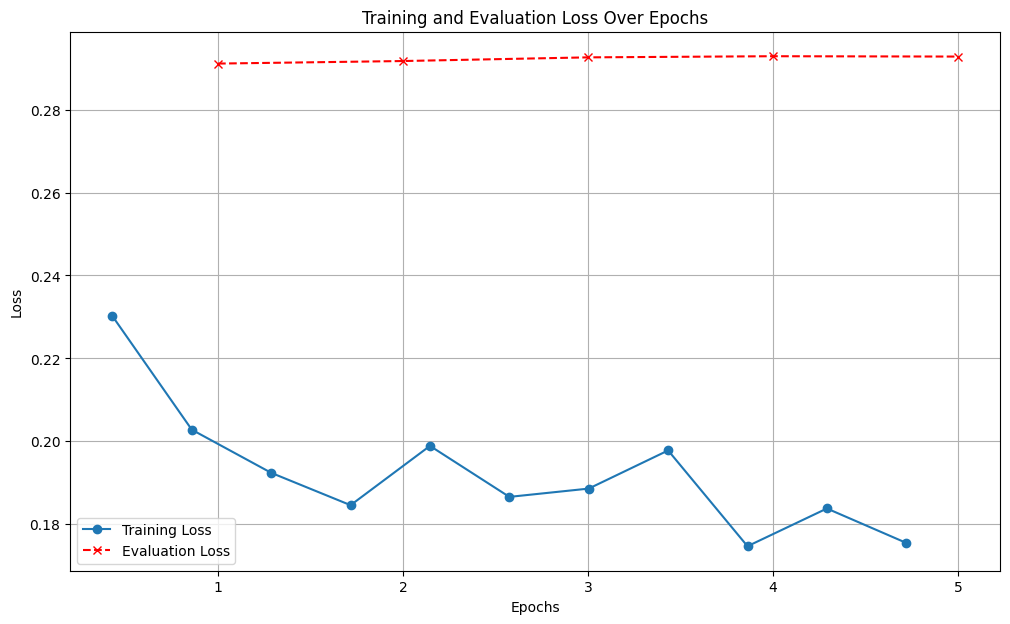

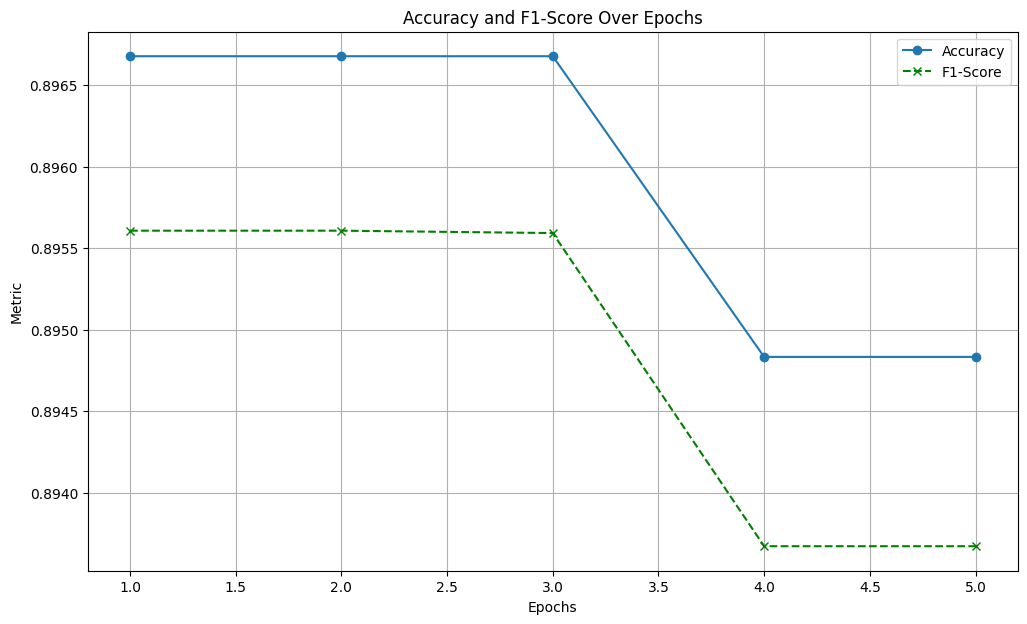

In [42]:
checkpoint = '233'
path_to_model = f'{new_output_dir}/checkpoint-{checkpoint}'
finetuned_model = BeitForImageClassification.from_pretrained(path_to_model)
feature_extractor = BeitImageProcessor.from_pretrained(path_to_model)

plot_graph(f'{new_output_dir}/trainer_state.json')

In [ ]:
finetuner = Trainer(
    model=finetuned_model,
    args=finetuning_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train_finetuned,
    eval_dataset=prepared_test_finetuned,
    processing_class=feature_extractor,
)

eval_results = finetuner.evaluate()

finetuner.log_metrics("eval", eval_results)
finetuner.save_metrics("eval", eval_results)

***** eval metrics *****
  eval_accuracy               =     0.8967
  eval_f1                     =     0.8956
  eval_loss                   =     0.2911
  eval_model_preparation_time =        0.0
  eval_runtime                = 0:00:24.90
  eval_samples_per_second     =     21.762
  eval_steps_per_second       =       2.73


The confusion matrix shows that FE1:
- is better than TE5 at classifying fungi images, but still struggles with pest images
- is just a bit worse at classifying virus images

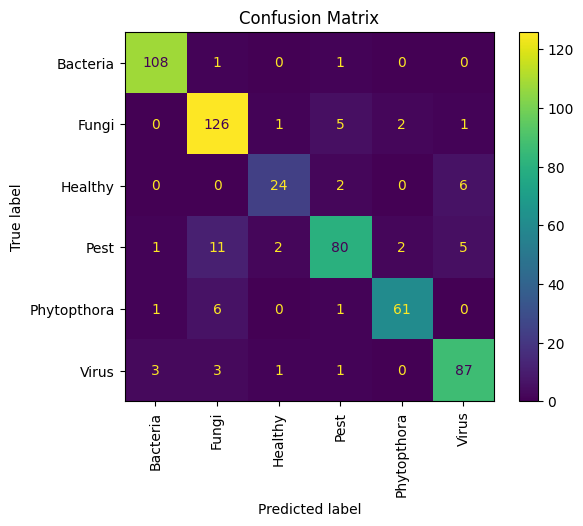

In [98]:
show_confusion_matrix(prepared_test_finetuned, finetuned_model)

### Predicting the images from potato_test

Now we finally use the finetuned model to predict the images from potato_test. The results will be stored in a CSV file named `beit_potato_predictions.csv`.

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from tqdm import tqdm # to show progress bar

potato_test_folder = 'potato_test'
output_csv_path = 'beit_potato_predictions.csv'

finetuned_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finetuned_model.to(device)
print(f"Using device: {device}")

finetuned_model.config.id2label = {
    0: 'Bacteria', 
    1: 'Fungi',
    2: 'Healthy',
    3: 'Pest',
    4: 'Phytopthora',
    5: 'Virus',}

id2label = finetuned_model.config.id2label

predictions_data = []

print(f"Processing images from: {potato_test_folder}")
image_files = [f for f in os.listdir(potato_test_folder) if os.path.isfile(os.path.join(potato_test_folder, f))]
image_files = [f for f in image_files if f.lower().endswith(('.jpeg'))]

for image_filename in tqdm(image_files, desc="Generating predictions"):
    image_path = os.path.join(potato_test_folder, image_filename)
    image = Image.open(image_path).convert("RGB")
    # Preprocess the image
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # Make a prediction
    with torch.no_grad(): # Disable gradient calculation for inference
        outputs = finetuned_model(**inputs)
    logits = outputs.logits # raw scores
    predicted_class_id = logits.argmax(-1).item() # gets highest score
    predicted_label = id2label.get(predicted_class_id, f"unknown_class_{predicted_class_id}")
    
    predictions_data.append({
        'image_filename': f"image_{image_filename}",
        'predicted_label': predicted_label
    })

predictions_df = pd.DataFrame(predictions_data)
predictions_df.to_csv(output_csv_path, index=False)
print(f"\nPredictions saved successfully to {output_csv_path}")

Using device: cuda
Processing images from: potato_test


Generating predictions: 100%|██████████| 301/301 [00:17<00:00, 17.29it/s]


Predictions saved successfully to potato_predictions.csv


Below shows the number of predicted labels from potato_test. If the model accurately predicted most of the images, then we can say that fungi images are most common images in potato_test.

In [ ]:
import pandas as pd

output_csv_path = 'potato_predictions.csv'
df = pd.read_csv(output_csv_path)

label_counts = df['predicted_label'].value_counts()
print(f"Counts of each predicted label from '{output_csv_path}':\n")
print(label_counts)

Counts of each predicted label from 'potato_predictions.csv':

predicted_label
Fungi          79
Bacteria       58
Virus          57
Pest           56
Phytopthora    34
Healthy        17
Name: count, dtype: int64
